# Making a injection vs structure projection matrix

Use SDK cache/functions to retreive metadata about the experiments

In [14]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# !! update this path so that it points to your external hard drive !!
mcc = MouseConnectivityCache(manifest_file='D:/connectivity/manifest.json')

# get metadata for all the experiments
all_experiments = mcc.get_experiments(dataframe=True)
print "There are %d experiments in the cache" % len(all_experiments)

There are 2173 experiments in the cache


Get ontology information

In [2]:
ontology = mcc.get_ontology()

# Experiment Filtering
Reduce the list of experiment to what you want to do your analysis

In [3]:
# EXAMPLE: Find all experiments that is wild and Rbp4-Cre_KL100 and injection within VIS or PTLp

include_lines = ['Rbp4-Cre_KL100','']
include_parent_structures = ['VIS','PTLp']
include_structures_id = ontology.get_descendant_ids(*ontology[include_parent_structures].id.values)

#
# NOTE: 
#
# (1) the werid input for get_descendant_ids is due to it wanting structures as independent input
# arguments - this is difficult to use!
#      ontology.get_descendant_ids(669,22)  - this works
#      ontology.get_descendant_ids([669,22]) - does not work
#
# (2) get_descendant_ids does not return itself - it should!
#
    
experiment_mask = (
    all_experiments['transgenic-line'].isin(include_lines) &
    all_experiments['structure-id'].isin(include_structures_id)
    )

filtered_experiments = all_experiments[experiment_mask]

# just picking  the top 4 because some structure unionizes files on my disk is corrupt
filtered_experiments = filtered_experiments[0:4]

print "There are %d experiments in my filtered experiment list" % len(filtered_experiments)


There are 4 experiments in my filtered experiment list


## Structure Filtering
Create the list of structures for which you want to report either injection or projection information

In [4]:
# EXAMPLE: Use the SDK to fetch the coarse 12 structural brain division

from allensdk.api.queries.ontologies_api import OntologiesApi

summary_structures = OntologiesApi().get_structures(structure_set_names='Mouse - Coarse')
summary_structure_ids = [ s['id'] for s in summary_structures ]

# order the structures by ontology graph order
filtered_structures = ontology[summary_structure_ids].sort('graph_order')
print "There are %d structures in my filtered structure list" % len(filtered_structures)

There are 12 structures in my filtered structure list


# Use helper function to make matrix

In [5]:
import connectivity_helper as chelp

In [6]:
test = chelp.generate_matrix( mcc, filtered_experiments, filtered_structures, [2,1],
                            is_injection=False, parameter='normalized_projection_volume')

In [7]:
test['matrix'].shape

(4L, 24L)

In [8]:
test['columns']

hemisphere_id        label  structure_id
0               2  Isocortex-R           315
1               2        OLF-R           698
2               2        HPF-R          1089
3               2      CTXsp-R           703
4               2        STR-R           477
5               2        PAL-R           803
6               2         TH-R           549
7               2         HY-R          1097
8               2         MB-R           313
9               2          P-R           771
10              2         MY-R           354
11              2         CB-R           512
12              1  Isocortex-L           315
13              1        OLF-L           698
14              1        HPF-L          1089
15              1      CTXsp-L           703
16              1        STR-L           477
17              1        PAL-L           803
18              1         TH-L           549
19              1         HY-L          1097
20              1         MB-L           313
21              1          P-L           771
22              1         MY-L           354
23              1         CB-L           512

In [9]:
test['matrix']

array([[  3.37778000e+01,   1.11757000e-01,   2.34832000e+00,
          6.88516000e-01,   5.76878000e+00,   7.30543000e-02,
          5.74697000e+00,   7.97948000e-02,   4.31661000e+00,
          1.64473000e-01,   6.34567000e-04,   2.61785000e-03,
          6.65890000e+00,   4.64310000e-02,   4.78270000e-01,
          7.92313000e-02,   1.21501000e+00,   1.53082000e-02,
          2.02145000e-02,   1.46279000e-02,   1.00727000e-01,
          2.11521000e-03,   8.68054000e-04,   1.57708000e-03],
       [  6.92477000e+00,   2.13456000e-02,   1.08492000e+00,
          1.58501000e-01,   1.14610000e+00,   1.60229000e-02,
          1.62995000e+00,   2.79198000e-02,   8.97200000e-01,
          4.85572000e-02,   1.83392000e-03,   4.87920000e-04,
          2.10795000e+00,   8.64456000e-03,   1.78728000e-01,
          9.91367000e-03,   1.06458000e-01,   3.15954000e-03,
          4.47924000e-03,   6.75170000e-03,   1.99193000e-02,
          2.04251000e-03,   2.04146000e-03,   1.97883000e-03],
      

Show matrix as heatmap using Lightning!
(pip install lightning-python)


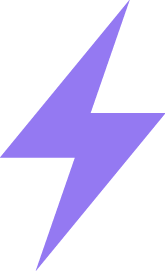

Running local mode, some functionality limited.



In [10]:
from lightning import Lightning
import numpy as np
lgn = Lightning(ipython=True, local=True)
lgn.set_size('full')

In [11]:
# label rows by primary injection site acronym
row_labels = filtered_experiments['structure-abbrev']

# label columns by structure-hemisphere
column_labels = test['columns']['label'].values

In [12]:
lgn.matrix(np.log10(test['matrix']), numbers=True, row_labels=row_labels, column_labels=column_labels)